In [2]:
'''
Models:

U Net for pix2pix type thing
Embedding model from scratch and with pretrained
Maybe another for multiple input?

ChannelEmbed?
'''

In [7]:
import torch, pandas as pd, numpy as np, math
from matplotlib import pyplot as plt
from PIL import Image
from torch import nn
%matplotlib inline 




In [20]:
def imgToArray(path,size = None, norm=True):
    print(12)
    im = Image.open(path)
    ar = np.asarray(im)[:,:,:3]
    if size:
        im = im.resize((size,size))
    if norm:
        ar = (ar-127.5)/127.5
    return ar

def arrayToIm(array,size = None):
    array = (array*127.5) + 127.5
    plt.imshow(array)


In [22]:
im = imgToArray('./test_photo.png',256)
print(im)
# arrayToIm(im)


12
[[[-0.25490196 -0.11372549 -0.09019608]
  [-0.2627451  -0.11372549 -0.09803922]
  [-0.2627451  -0.11372549 -0.09803922]
  ...
  [-0.34117647 -0.41960784 -0.01960784]
  [-0.34117647 -0.42745098 -0.01960784]
  [-0.34901961 -0.42745098 -0.02745098]]

 [[-0.24705882 -0.11372549 -0.09019608]
  [-0.25490196 -0.11372549 -0.09803922]
  [-0.2627451  -0.11372549 -0.09803922]
  ...
  [-0.34901961 -0.41960784 -0.01960784]
  [-0.34901961 -0.42745098 -0.01960784]
  [-0.34901961 -0.42745098 -0.02745098]]

 [[-0.24705882 -0.11372549 -0.09019608]
  [-0.24705882 -0.11372549 -0.09019608]
  [-0.25490196 -0.11372549 -0.09019608]
  ...
  [-0.35686275 -0.42745098 -0.02745098]
  [-0.35686275 -0.42745098 -0.02745098]
  [-0.35686275 -0.42745098 -0.02745098]]

 ...

 [[ 0.08235294  0.03529412 -0.03529412]
  [ 0.08235294  0.03529412 -0.03529412]
  [ 0.08235294  0.03529412 -0.03529412]
  ...
  [-0.48235294 -0.63921569 -0.7254902 ]
  [-0.48235294 -0.63921569 -0.7254902 ]
  [-0.48235294 -0.63921569 -0.7254902 ]]


In [ ]:
def init_weights(m):
    if isinstance(nn.Conv2d):
        torch.nn.init.normal_(m.weight, std=0.02)
        

In [86]:
class upsample(nn.Module):
    '''layer for up sampling. Two inputs which are catted together than blown up'''
    def __init__(self,in_channels,out_channels,kernel_size, batch_norm = True):
        super(upsample, self).__init__()
        self.layers = nn.ModuleList([nn.ConvTranspose2d(in_channels*2,
                                               out_channels,
                                               kernel_size,
                                               stride = 2,
                                               padding=1
                                               )])
        if batch_norm:
            self.layers.append(nn.BatchNorm2d(out_channels))
        self.layers.append(nn.LeakyReLU())

    def forward(self,inputs):
        #expects tuple of (normal, skip)
        x = torch.concat(inputs,dim = 1)
        
        
        print(x.shape)
        for layer in self.layers:
            x = layer(x)
        
        return x
    

In [76]:
m = nn.ConvTranspose2d(16,5,4,stride = 2,padding=1)
input = torch.rand(10,16,64,64)
m(input).shape

torch.Size([10, 5, 128, 128])

In [88]:
down = upsample(16,32,4)
input = torch.rand(10,16,64,64)

down((input,input))[1].shape

torch.Size([10, 32, 64, 64])


torch.Size([32, 128, 128])

In [161]:
class downsample(nn.Module):
    '''encoder block for generator'''
    def __init__(self,in_channels, out_channels,kernel_size=4, upsample_scheme='nearest', dropout = None):
        super(downsample,self).__init__()
        self.Layers = nn.ModuleList([nn.Conv2d(in_channels, 
                                                        out_channels,
                                                        kernel_size,
                                                        padding = 'same',
                                                        stride=1)])

        self.Layers.append(nn.BatchNorm2d(out_channels))
        if dropout:
            self.Layers.append(nn.Dropout2d(dropout))
        self.Layers.append(nn.LeakyReLU())
        self.downsample = nn.MaxPool2d(2)
    def forward(self,inputs):
        x = inputs
        for layer in self.Layers:
            x = layer(x)

        x_down = self.downsample(x)
        return x_down, x
            
    

In [160]:
down = downsample(3,128,4)
test = torch.rand((4,3,64,64))
down(test)[0].shape

torch.Size([4, 128, 64, 64])

In [206]:
class U_Gen(nn.Module):
    '''U net Generator'''
    def __init__(self,input_size, kernel_size = 4, dropout = None):
        super(U_Gen,self).__init__()
        self.init_embed = nn.Conv2d(3,64,4,padding='same')
        self.final_embed = nn.Conv2d(64,3,kernel_size)

        
        
        self.down_sampling = nn.ModuleList([])
        self.up_sampling = []
        
        assert(math.log2(input_size) == int(math.log2(input_size)))
        
        curr_channel_no = 64
        while input_size >= 12:
            self.down_sampling.append(downsample(curr_channel_no,
                                                 curr_channel_no*2,
                                                 kernel_size
                                                 ))
            self.up_sampling.append(upsample(curr_channel_no*2, 
                                             curr_channel_no,
                                             kernel_size))
                            
            print(curr_channel_no)
            input_size /= 2 
            curr_channel_no *= 2 

        self.deep_embed = nn.Conv2d(curr_channel_no, 
                                    curr_channel_no*2,
                                    kernel_size,
                                    padding = 'same')
        list.reverse(self.up_sampling)
        self.up_sampling = nn.ModuleList(self.up_sampling)
    def forward(self,input):
        skips = []
        x = self.init_embed(input)

        for layer in self.down_sampling:
            x, skip = layer(x)
            skips.append(skip)

        x = (skip)
        n = len(skips)
        print(x.shape)
        # for i,tensor in enumerate(skips):
        #     print(tensor.shape, i)
        for i,layer in enumerate(self.up_sampling):
            skip = skips[n - (i + 1)]
            print(x.shape,skip.shape)
            x =  layer((x, skip))
            print(i,'yippe')

        x = self.final_embed(x)
        return x 

        

In [14]:
test = torch.rand(4,3,128,128)

im = Image.open('./test_photo.png')
im_array = imgToArray('./test_photo.png',256)
arrayToIm(im_array)
print(im_array)
# u_gen = U_Gen(64)
# print(u_gen(test).shape)
# print(len(u_gen.up_sampling))
# for i in range(len(u_gen.up_sampling)):
#     print(u_gen.down_sampling[i], u_gen.up_sampling[i])

12


TypeError: Cannot handle this data type: (1, 1, 3), <f8

In [53]:
# class U_Disc(nn.Module):
#     '''U net discriminator'''
#     def __init__(self,kernel_size=4, num_downsamples = 3, dropout = None,):
#         super(U_Disc, self).__init__()
#         self.init_conv = nn.Conv2d(6,64,kernel_size)
        
#         self.downsample_layers = nn.ModuleList(
#                 [Downsample(kernel_size,64*(2**i),64*(2**(i+1)),drop_out=dropout) 
#                  for i in range(0,num_downsamples)]
#                                                 )
#         self.conv1 = nn.Conv2d(64*(2**num_downsamples),512,kernel_size)
#         self.batch_norm1 = nn.BatchNorm2d(512)
#         self.relu1 = nn.ReLU()
        
#         self.final = nn.Conv2d(512,1, kernel_size)
        
#     def forward(self,inputs):
#         '''
#         takes as input a tuple (x,t) 
#         where x is the input and t is the target
#         '''
#         input_im, target_im = inputs
#         concat = torch.concat([input_im,target_im], dim = 1)
#         x = self.init_conv(concat)
        
#         print(x.shape)
#         for layer in self.downsample_layers:
#             print(x.shape)
#             x = layer(x)
#         print("?")
#         x = self.conv1(x)
#         x = self.batch_norm1(x)
#         x = self.relu1(x)
        
#         x = self.final(x)
#         return x
        
        
        
        
        

In [54]:
for i in range(3):
    print(64*(2**i),64*(2**(i+1)))

64 128
128 256
256 512


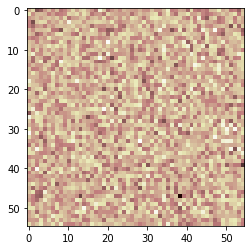

In [76]:
out_im = out[0,0].detach()
plt.imshow(out_im, cmap='pink', interpolation='nearest')
plt.show()

In [123]:
from PIL import Image
  

image = Image.open('tx.jpg')
ri = image.resize((256,256))
arry = np.asarray(ri)
arry.shape

(256, 256, 3)

In [124]:
arry.shape
r_shap = arry.reshape(1,3,256,256)
r_shap = torch.Tensor((r_shap - 127.5)/256)

In [125]:
u = U_Disc()
inputs = (r_shap,r_shap)
out = u(inputs)

torch.Size([1, 64, 253, 253])
torch.Size([1, 64, 253, 253])
torch.Size([1, 128, 125, 125])
torch.Size([1, 256, 61, 61])
?


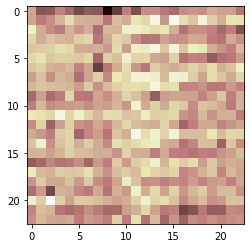

In [126]:
out_im = out[0,0].detach()
plt.imshow(out_im, cmap='pink', interpolation='nearest')
plt.show()